## Compositional explanations for neurons

In [ ]:
import os
#virtually move to parent directory
os.chdir("..")

In [1]:

import torch
from itertools import permutations
from matplotlib import pyplot as plt

import clip
import utils
import data_utils
import similarity

## Settings

In [2]:
clip_name = 'ViT-B/16'
target_name = 'resnet50'
target_layer = 'layer4'
d_probe = 'imagenet_broden'
concept_set = 'data/20k.txt'

batch_size = 200
device = 'cuda'
pool_mode = 'avg'

save_dir = 'saved_activations'
similarity_fn = similarity.soft_wpmi

## Setup

In [3]:
utils.save_activations(clip_name = clip_name, target_name = target_name, target_layers = [target_layer], 
                       d_probe = d_probe, concept_set = concept_set, batch_size = batch_size, 
                       device = device, pool_mode=pool_mode, save_dir = save_dir)

save_names = utils.get_save_names(clip_name = clip_name, target_name = target_name,
                                  target_layer = target_layer, d_probe = d_probe,
                                  concept_set = concept_set, pool_mode=pool_mode,
                                  save_dir = save_dir)

target_save_name, clip_save_name, text_save_name = save_names

with open(concept_set, 'r') as f:
    words = f.read().split('\n')

pil_data = data_utils.get_data(d_probe)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /tmp/xdg-cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 213MB/s]
100%|██████████| 567/567 [01:20<00:00,  7.05it/s]


## Find combination explanations using CLIP-Dissect

100%|██████████| 2048/2048 [01:21<00:00, 25.05it/s]


torch.Size([2048, 10000])

 Layer:layer4 Neuron:386
Top:1, Orig:textile, New:flores embroidery
Top:2, Orig:embroidered, New:motif embroidered


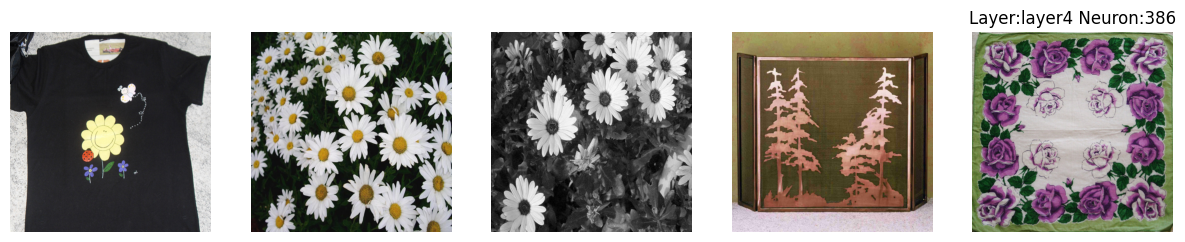

100%|██████████| 2048/2048 [01:16<00:00, 26.69it/s]


torch.Size([2048, 20000])


100%|██████████| 2048/2048 [01:20<00:00, 25.37it/s]


torch.Size([2048, 10000])

 Layer:layer4 Neuron:1617
Top:1, Orig:tournament, New:ping athlete
Top:2, Orig:ping, New:tournaments hannover


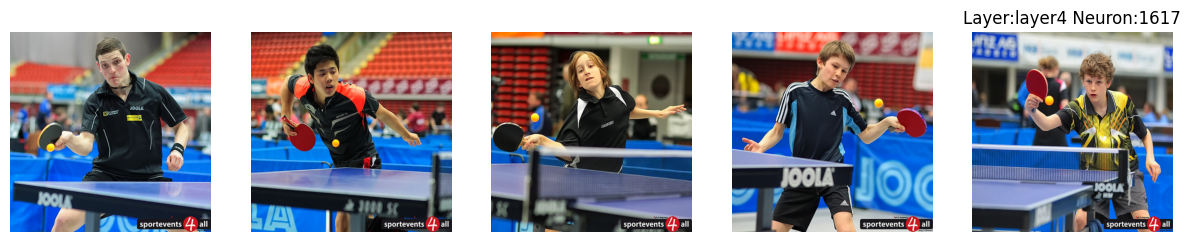

100%|██████████| 2048/2048 [01:24<00:00, 24.19it/s]


torch.Size([2048, 20000])


100%|██████████| 2048/2048 [01:21<00:00, 25.07it/s]


torch.Size([2048, 10000])

 Layer:layer4 Neuron:25
Top:1, Orig:chair, New:chair rocker
Top:2, Orig:chairs, New:hospice chair


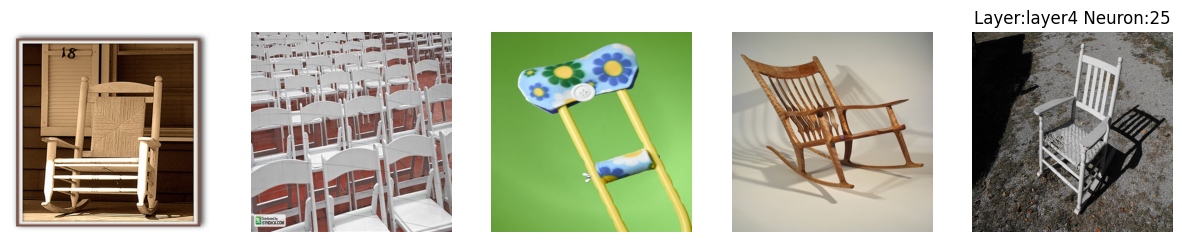

100%|██████████| 2048/2048 [01:24<00:00, 24.22it/s]


torch.Size([2048, 20000])


100%|██████████| 2048/2048 [01:21<00:00, 25.23it/s]


torch.Size([2048, 10000])

 Layer:layer4 Neuron:500
Top:1, Orig:tp, New:bathrooms tissue
Top:2, Orig:tissue, New:paper toilet


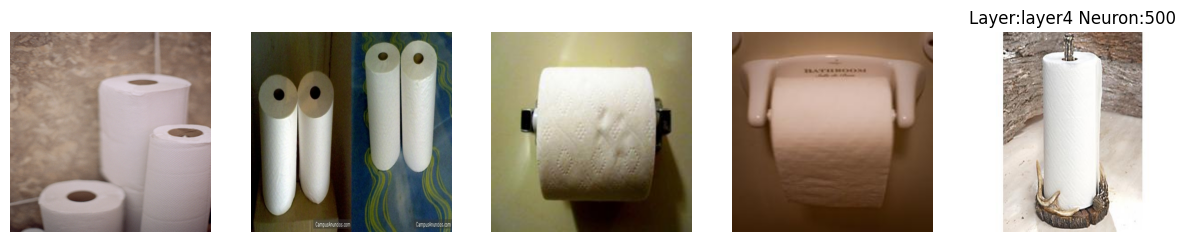

100%|██████████| 2048/2048 [01:22<00:00, 24.90it/s]


torch.Size([2048, 20000])


100%|██████████| 2048/2048 [01:19<00:00, 25.90it/s]


torch.Size([2048, 10000])

 Layer:layer4 Neuron:750
Top:1, Orig:armour, New:anglican armour
Top:2, Orig:armor, New:anglican armor


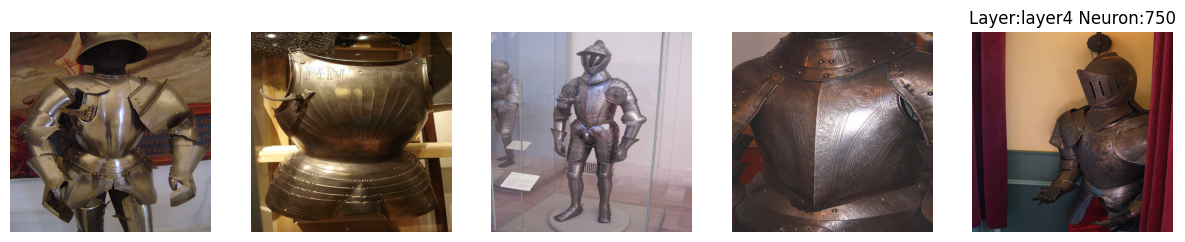

100%|██████████| 2048/2048 [01:12<00:00, 28.26it/s]


torch.Size([2048, 20000])


100%|██████████| 2048/2048 [01:21<00:00, 25.24it/s]


torch.Size([2048, 10000])

 Layer:layer4 Neuron:1000
Top:1, Orig:barn, New:auditorium barn
Top:2, Orig:auditorium, New:farmhouse auditorium


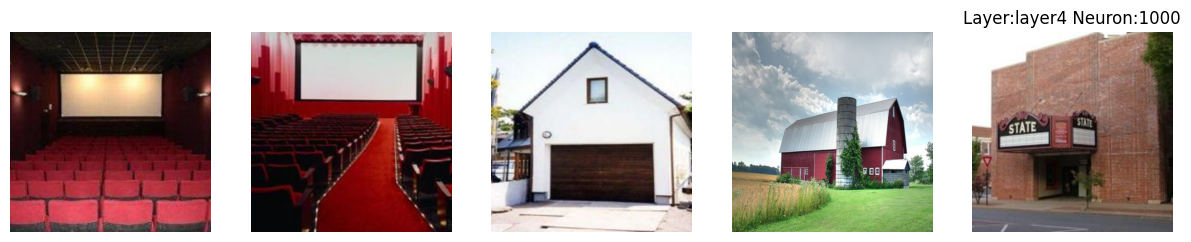

100%|██████████| 2048/2048 [01:20<00:00, 25.52it/s]


torch.Size([2048, 10000])

 Layer:layer4 Neuron:1250
Top:1, Orig:pharmacist, New:microbiology apron
Top:2, Orig:scientist, New:microbiology coat


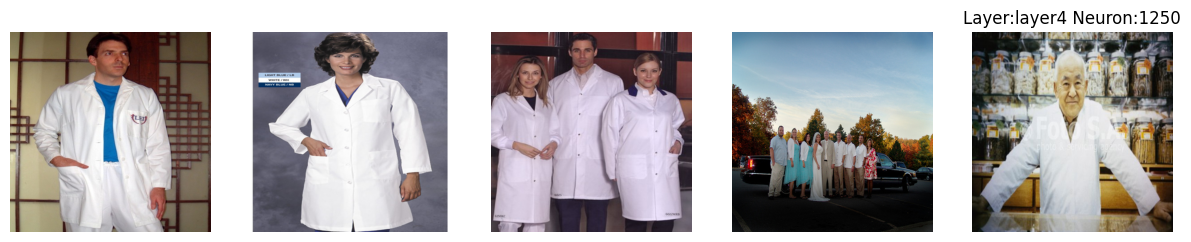

100%|██████████| 2048/2048 [01:21<00:00, 25.22it/s]


torch.Size([2048, 20000])


100%|██████████| 2048/2048 [01:21<00:00, 25.23it/s]


torch.Size([2048, 10000])

 Layer:layer4 Neuron:1500
Top:1, Orig:wetland, New:wetland juvenile
Top:2, Orig:juvenile, New:wetland mating


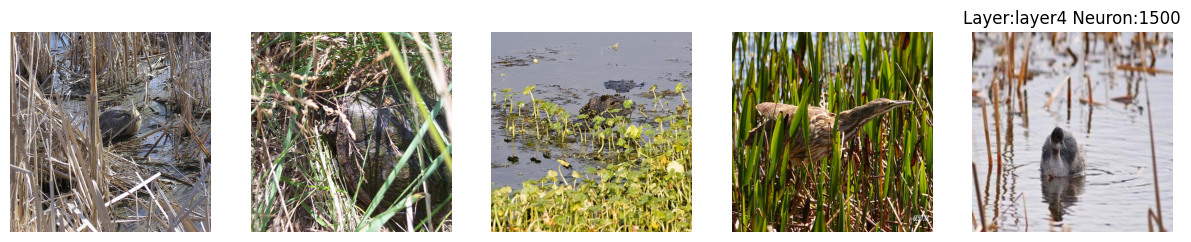

In [5]:
clip_model, clip_preprocess = clip.load(clip_name, device=device)
ids_of_interest = [386, 1617, 25,500,750,1000,1250,1500]

for id_of_interest in ids_of_interest:
    similarities, target_feats = utils.get_similarity_from_activations(target_save_name, clip_save_name, 
                                                                       text_save_name, similarity_fn, device=device)
    target_feats = target_feats.cpu()
    vals, ids = torch.topk(similarities[id_of_interest], k=5, largest=True)
    orig_words = [words[int(ids[i])] for i in range(len(vals))]

    vals, ids = similarities[id_of_interest].topk(100, largest=True)
    del similarities
    torch.cuda.empty_cache()
    
    #create new concept set
    top_words = [words[ind] for ind in ids]

    new_words = permutations(top_words, r=2)
    new_words = [word1+' '+word2 for word1, word2 in new_words]
    new_words.extend(top_words)
    
    #recalculate similarities
    text = clip.tokenize(["{}".format(word) for word in new_words]).to(device)
    with torch.no_grad():
        image_features = torch.load(clip_save_name)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        
        text_features = utils.get_clip_text_features(clip_model, text, batch_size=1000)
        text_features /= text_features.norm(dim=-1, keepdim=True)
    clip_feats = (image_features @ text_features.T).cpu().float()
    del image_features, text_features
    torch.cuda.empty_cache()
    
    similarities = similarity_fn(clip_feats, target_feats)
    top_vals, top_ids = torch.topk(target_feats, k=5, dim=0)

    print('\n Layer:{} Neuron:{}'.format(target_layer, (int(id_of_interest))))
    
    vals, ids = torch.topk(similarities[id_of_interest], k=2, largest=True)
    del similarities, clip_feats
    torch.cuda.empty_cache()
    
    for i in range(len(vals)):
        print("Top:{}, Orig:{}, New:{}".format(i+1, orig_words[i], new_words[int(ids[i])]))

    fig = plt.figure(figsize=(15, 7))
    for i, top_id in enumerate(top_ids[:, id_of_interest]):
        im, label = pil_data[top_id]
        im = im.resize([375,375])
        fig.add_subplot(1, 5, i+1)
        plt.imshow(im)
        plt.axis('off')
        
    plt.title('Layer:{} Neuron:{}'.format(target_layer, (int(id_of_interest))))
    plt.show()